In [1]:
# import display libs
from IPython.display import Image
%matplotlib inline
from IPython.display import Latex

#TEST!!!

In [2]:
# import libs
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt


# setup figure params
figureparams = {'axes.labelsize': 24,
           'axes.titlesize': 20,
           'axes.linewidth': 1.3,
           'font.size': 20,
           'legend.fontsize': 18,
           'figure.figsize': (10,7),
           'font.family': 'serif',
           'font.serif': 'Computer Modern Roman',
           'xtick.labelsize': 18,
           'xtick.major.size': 5.5,
           'xtick.major.width': 1.3,
           'ytick.labelsize': 18,
           'ytick.major.size': 5.5,
           'ytick.major.width': 1.3,
           'text.usetex': True,
           'figure.autolayout': True}
plt.rcParams.update(figureparams)
matplotlib.rcParams['text.usetex']=False
matplotlib.rcParams['text.latex.unicode']=True
matplotlib.get_configdir()

C:\Users\RJANSEN\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.


'C:\\Users\\RJANSEN\\.matplotlib'

# ARIMA

AutoRegressive Integrated Moving Average

In [3]:
# Import additional libs
import warnings
import itertools
import statsmodels.api as sm

In [5]:
# Load the data
df = pd.read_csv('international-airline-passengers.csv', engine='python', skipfooter=3)
# A bit of pre-processing to make it nicer
df['Month']=pd.to_datetime(df['Month'], format='%Y-%m-%d')
df.set_index(['Month'], inplace=True)
cols = df.columns

cols

Index(['International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [6]:
df


,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


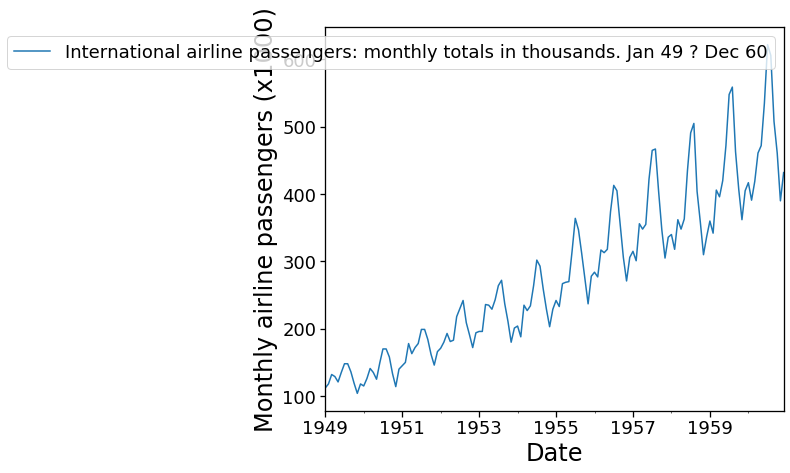

In [8]:
# Plot the data
df.plot()
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.show()

## ARIMA

ARIMA stands for Auto-Regressive Integrated Moving Average. There are three integers (p, d, q) that are used to parametrize ARIMA models. Because of that, a nonseasonal ARIMA model is denoted with ARIMA(p, d, q):

- __p__ is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
- __d__ is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
- __q__ is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

When dealing with seasonal effects, as in our example, seasonal ARIMA is used, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the nonseasonal parameters described above, (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series.

While in this case it is clear that s=12, how do we set the other parameters?

It is pretty much based on experience. There are numerous best practices that can be followed to identify ARIMA models, such as: http://people.duke.edu/~rnau/arimrule.htm.

Here we use grid search over all possible combinations of parameter values within a predefined range of values (heavily inspired by https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3).

$statsmodels.tsa.statespace.sarimax.SARIMAXResults$ returns values for AIC (Akaike Information Criterion) and BIC (Bayes Information Criterion) that can be minimized to select the best fitting model. We use the AIC value, which estimates the information lost when a given model is used to represent the process that generates the data. In doing so, it deals with the trade-off between the goodness of fit of the model and the complexity of the model itself.


In [10]:
# Define the d and q parameters to take any value between 0 and 1
q = d = range(0, 2)
# Define the p parameters to take any value between 0 and 3
p = range(0, 4)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


## Split Train/Test

In [11]:
train_data = df['1949-01-01':'1959-12-01']
test_data = df['1960-01-01':'1960-12-01']

## Setup model

In [12]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_data,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{} - AIC:{}'.format(param, param_seasonal, results.aic)) #, end='\r')  # print same line
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 0, 12) - AIC:1853.867132204165
SARIMAX(0, 0, 0)x(0, 0, 1, 12) - AIC:1575.2927100521529
SARIMAX(0, 0, 0)x(0, 1, 0, 12) - AIC:1183.7768361260032
SARIMAX(0, 0, 0)x(0, 1, 1, 12) - AIC:1039.3684612710642
SARIMAX(0, 0, 0)x(1, 0, 0, 12) - AIC:1018.1128824449078
SARIMAX(0, 0, 0)x(1, 0, 1, 12) - AIC:1008.0082399525209
SARIMAX(0, 0, 0)x(1, 1, 0, 12) - AIC:999.1896494904967
SARIMAX(0, 0, 0)x(1, 1, 1, 12) - AIC:930.7565628459041
SARIMAX(0, 0, 0)x(2, 0, 0, 12) - AIC:925.3776421812721
SARIMAX(0, 0, 0)x(2, 0, 1, 12) - AIC:919.709657988423
SARIMAX(0, 0, 0)x(2, 1, 0, 12) - AIC:860.9989449358327
SARIMAX(0, 0, 0)x(2, 1, 1, 12) - AIC:829.7168124306413
SARIMAX(0, 0, 0)x(3, 0, 0, 12) - AIC:823.5135507691754
SARIMAX(0, 0, 0)x(3, 0, 1, 12) - AIC:816.8556116830363
SARIMAX(0, 0, 0)x(3, 1, 0, 12) - AIC:757.5069329715909
SARIMAX(0, 0, 0)x(3, 1, 1, 12) - AIC:731.0692079438643
SARIMAX(0, 0, 1)x(0, 0, 0, 12) - AIC:1670.9731705571571
SARIMAX(0, 0, 1)x(0, 0, 1, 12) - AIC:1409.630843618917
SARIM

SARIMAX(2, 0, 1)x(1, 0, 1, 12) - AIC:867.9865745411637
SARIMAX(2, 0, 1)x(1, 1, 0, 12) - AIC:812.7531360568036
SARIMAX(2, 0, 1)x(1, 1, 1, 12) - AIC:819.2148652753186
SARIMAX(2, 0, 1)x(2, 0, 0, 12) - AIC:790.1051388000292
SARIMAX(2, 0, 1)x(2, 0, 1, 12) - AIC:791.1356956768362
SARIMAX(2, 0, 1)x(2, 1, 0, 12) - AIC:727.6832286713974
SARIMAX(2, 0, 1)x(2, 1, 1, 12) - AIC:727.7067262201385
SARIMAX(2, 0, 1)x(3, 0, 0, 12) - AIC:706.8316795978928
SARIMAX(2, 0, 1)x(3, 0, 1, 12) - AIC:708.838478060724
SARIMAX(2, 0, 1)x(3, 1, 0, 12) - AIC:639.2744345078823
SARIMAX(2, 0, 1)x(3, 1, 1, 12) - AIC:639.1815864236905
SARIMAX(2, 1, 0)x(0, 0, 0, 12) - AIC:1244.943793039306
SARIMAX(2, 1, 0)x(0, 0, 1, 12) - AIC:1062.962189178121
SARIMAX(2, 1, 0)x(0, 1, 0, 12) - AIC:887.9461009088055
SARIMAX(2, 1, 0)x(0, 1, 1, 12) - AIC:811.6372942248554
SARIMAX(2, 1, 0)x(1, 0, 0, 12) - AIC:879.8872714297042
SARIMAX(2, 1, 0)x(1, 0, 1, 12) - AIC:864.4989719032022
SARIMAX(2, 1, 0)x(1, 1, 0, 12) - AIC:803.7749868576251
SARIMAX(2, 

In [13]:
# print best result
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 618.2055119814877 for model SARIMAX(3, 1, 0)x(3, 1, 1, 12)


In [14]:
# fit model
mod = sm.tsa.statespace.SARIMAX(train_data,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


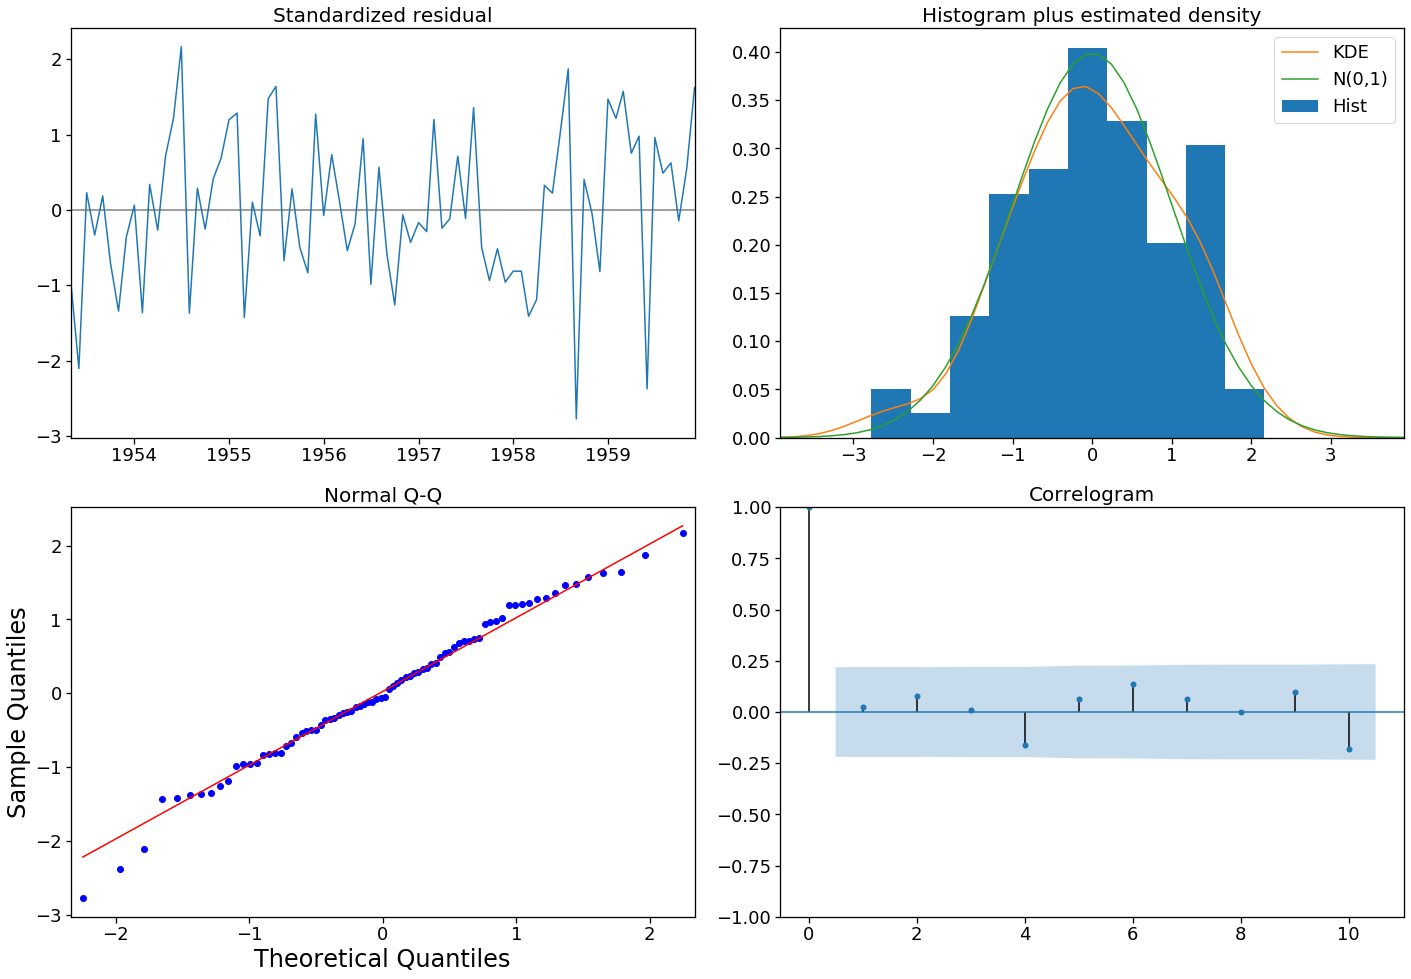

In [15]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()

## Results

1) In sample prediction with 1-step ahead forecasting of the last year (1959). In this case the model is used to predict data that the model was built on. 1-step ahead forecasting implies that each forecasted point is used to predict the following one.

In [16]:
pred0 = results.get_prediction(start='1958-01-01', dynamic=False)
pred0_ci = pred0.conf_int()

2) In sample prediction with dynamic forecasting of the last year (1959). Again, the model is used to predict data that the model was built on.

In [17]:
pred1 = results.get_prediction(start='1958-01-01', dynamic=True)
pred1_ci = pred1.conf_int()

3) "True" forecasting of out of sample data. In this case the model is asked to predict data it has not seen before.

In [18]:
pred2 = results.get_forecast('1962-12-01')
pred2_ci = pred2.conf_int()
print(pred2.predicted_mean['1960-01-01':'1960-12-01'])

1960-01-01    419.493679
1960-02-01    397.831215
1960-03-01    460.856214
1960-04-01    449.448269
1960-05-01    474.552700
1960-06-01    537.848229
1960-07-01    614.884569
1960-08-01    628.209733
1960-09-01    519.333718
1960-10-01    462.251804
1960-11-01    412.160210
1960-12-01    452.660163
Freq: MS, dtype: float64


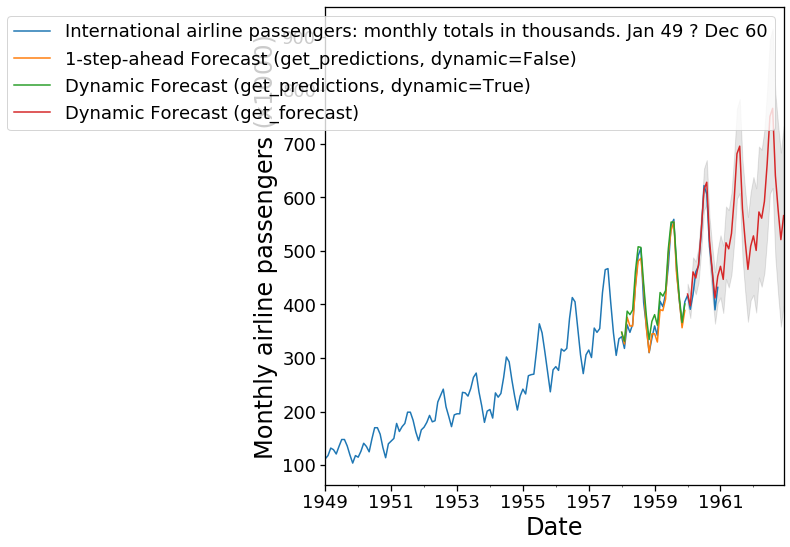

In [20]:
ax = df.plot(figsize=(10, 8))
pred0.predicted_mean.plot(ax=ax, label='1-step-ahead Forecast (get_predictions, dynamic=False)')
pred1.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_predictions, dynamic=True)')
pred2.predicted_mean.plot(ax=ax, label='Dynamic Forecast (get_forecast)')
ax.fill_between(pred2_ci.index, pred2_ci.iloc[:, 0], pred2_ci.iloc[:, 1], color='k', alpha=.1)
plt.ylabel('Monthly airline passengers (x1000)')
plt.xlabel('Date')
plt.legend()
plt.show()

Looking at the figure, the model seems to do a pretty good job at modeling the time series. The blue and purple lines are, as expected, very close to the red ground truth. What is more interesting is the gray line, the out of sample predinction. For such a simple time series, the ARIMA model is able to forecast the 1960 values accurately.

In order to quantify the accuracy of the prediction for 1960, we can compute metrics such as Mean Absolute Error, Mean Squared Error, or Root Mean Squared Error. These are all absolute metrics, are therefore scale-dependent. While they are useful, and widely used to compare different methods on a same dataset, here it would be more useful to express the error relatively to the magnitude of the time series we are trying to predict. One commonly-used percentage error measure is the Mean Absolute Percentage Error (MAPE). It has some drawbacks in special cases (notably, it can lead to division by zero) and improved measures have been proposed, see e.g. https://www.otexts.org/fpp/2/5 for a nice overview. However, for this example we'll stick with MAPE.

In [ ]:
prediction = pred2.predicted_mean['1960-01-01':'1960-12-01'].values
# flatten nested list
truth = list(itertools.chain.from_iterable(test_data.values))
# Mean Absolute Percentage Error
MAPE = np.mean(np.abs((truth - prediction) / truth)) * 100

print('The Mean Absolute Percentage Error for the forecast of year 1960 is {:.2f}%'.format(MAPE))